In [34]:
import xarray as xr
import numpy as np

data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
a = xr.DataArray(np.random.randn(3), [data.coords["y"]])
b = xr.DataArray(np.random.randn(4), dims="z")
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.68762745,  0.74088116,  1.14728931],
       [-0.22431243,  1.81285365,  0.56789508]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [64]:
labels = xr.DataArray(["E", "O", "E"], [data.coords["y"]], name="labels")
data.groupby(labels).mean("y")

<xarray.DataArray (x: 2, labels: 2)>
array([[0.91745838, 0.74088116],
       [0.17179133, 1.81285365]])
Coordinates:
  * x        (x) int64 10 20
  * labels   (labels) object 'E' 'O'

In [65]:
import salem
from pyproj import Proj, Transformer
from samgeo.common import reproject
import rasterio
import numpy as np
import netCDF4 as nc


auDomainGrid = "../inputs/geo_em.d01.nc"
landUsePath = "../inputs/NLUM_ALUMV8_250m_2015_16_alb.tif"
NTL = "../inputs/nasa-nighttime-lights.tiff"

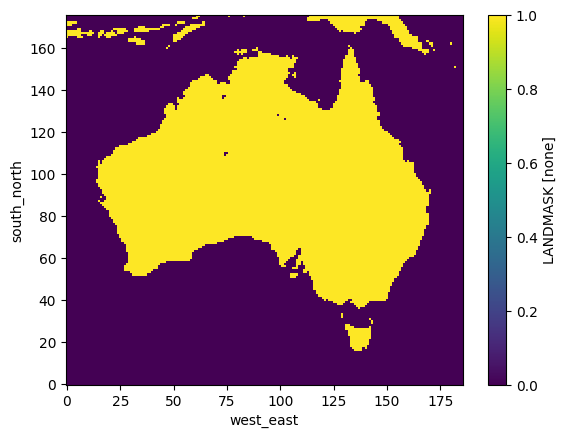

In [69]:
opened = xr.open_dataset(auDomainGrid)
opened.LANDMASK.plot()

In [3]:
ds = nc.Dataset(auDomainGrid)
wrf_proj = Proj(proj='lcc', lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, a=6370000, b=6370000)

reproject(landUsePath, "../outputs/LU.tif", wrf_proj.crs)
reproject(NTL, "../outputs/NTL.tif", wrf_proj.crs)

Reading input: /Users/gerardmason/code/openmethane-prior/outputs/LU.tif

Adding overviews...
Updating dataset tags...
Writing output to: /Users/gerardmason/code/openmethane-prior/outputs/LU.tif
Reading input: /Users/gerardmason/code/openmethane-prior/outputs/NTL.tif

Adding overviews...
Updating dataset tags...
Writing output to: /Users/gerardmason/code/openmethane-prior/outputs/NTL.tif


In [5]:
import netCDF4 as nc
ds = nc.Dataset(auDomainGrid)

In [9]:
ds.TRUELAT1

-15.0

In [50]:
landuseData = rasterio.open("NTL.tif")
transformer = Transformer.from_crs(landuseData.crs, wrf_proj.crs)
dest = np.zeros(landuseData.shape, dtype=np.uint8)

ntlt = landuseData.read(1) + landuseData.read(2) + landuseData.read(3)
ntlt_n = ntlt / np.sum(ntlt)

0.9999999999999964

In [30]:
def testXY(x, y):
    x2, y2 = landuseData.xy(x, y)
    x3, y3 = transformer.transform(x2, y2)
    # lon0, lat0 = lu_proj(x2, y2, inverse=True)
    lon1, lat1 = wrf_proj(x3, y3, inverse=True)
    # print(f"{lon0-lon1} {lat0-lat1}")
    print(lon1, lat1)

testXY(5129, 2530)
testXY(11385, 3266)
testXY(7602, 1322)

120.45152277933124 -46.91654120585416
122.53927535758895 -82.69079787239306
99.95954579254223 -62.584958201189714


In [41]:
import cv2   
import numpy as np
cv2.imwrite('_ntl.png', ntlt_n)

True

In [86]:
import pandas as pd
sectors = pd.read_csv("../inputs/ch4-sectoral-emissions.csv").to_dict(orient='records')[0]


2.2825


/Users/gerardmason/.pyenv/versions/3.11.2/lib/python3.11/site-packages/rasterio/features.py:324: ShapeSkipWarning: Invalid or empty shape None at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


TypeError: Invalid shape (1, 15365, 15963) for image data

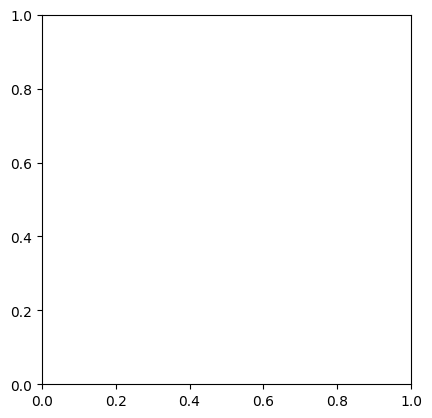

In [144]:
import rioxarray as rxr
import fiona
from matplotlib import pyplot
import geopandas
import pyproj

ds = xr.open_dataset("../outputs/om-geo_em.d01.nc")
domainProj = pyproj.Proj(proj='lcc', lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, a=6370000, b=6370000)
# with fiona.open("../inputs/AUS_2021_AUST_SHP_GDA2020/AUS_2021_AUST_GDA2020.shp", "r") as sf:
#     shapes = [feature["geometry"] for feature in sf]
geodf = geopandas.read_file("../inputs/AUS_2021_AUST_SHP_GDA2020/AUS_2021_AUST_GDA2020.shp")
geodf_r = geodf.to_crs(domainProj.crs)

# with rxr.open_rasterio("../outputs/land-use.tif") as lu:
#     print(geodf_r.crs, lu.rio.crs)

with rxr.open_rasterio("../outputs/land-use.tif") as src:
    # print(geodf.crs, src.rio.crs)
    clipped = src.rio.clip(geodf_r.geometry.values, geodf_r.crs)

clipped.plot()
    
# ShapeMask = rasterio.features.geometry_mask(sf.iloc[0],
#                                       out_shape=(len(ndvi.y), len(ndvi.x)),
#                                       transform=ndvi.geobox.transform,
#                                       invert=True)

# ((ds["OCH4_FUGITIVE"] * 100) + (ds["LANDMASK"] * 0.2)).plot()